In [1]:
import sys
sys.path.append("..")

In [2]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as L
import torch
from torchvision.transforms.functional import to_tensor
from torchvision.utils import draw_segmentation_masks
from src.data import parse_annotations
from src.models import get_maskrcnn

# Load dataset 2 images

In [3]:
DATA = Path("../data/hubmap")

In [4]:
tm = pd.read_csv(DATA / "tile_meta.csv")
tm.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [5]:
mask = tm["dataset"] == 2
mask.sum(), len(tm)

(1211, 7033)

In [6]:
image_ids = tm.loc[mask, "id"].to_list()
len(image_ids), image_ids[:5]

(1211,
 ['0006ff2aa7cd',
  '00168d1b7522',
  '003504460b3a',
  '004daf1cbe75',
  '005715f0a313'])

In [7]:
def load_image(img_id):
    img_path = DATA / "train" / f"{img_id}.tif"
    image = cv2.imread(str(img_path))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

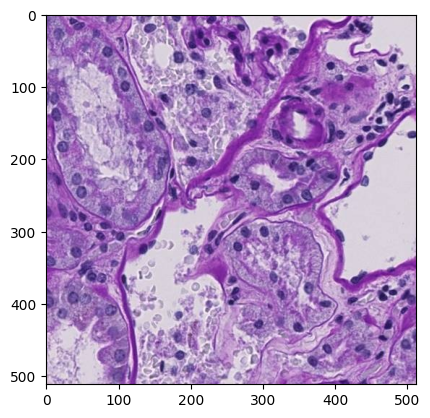

In [8]:
image = load_image(image_ids[434])
plt.imshow(image)

In [9]:
polygons = pd.read_json(DATA / "polygons.jsonl", lines=True)
polygons = polygons.set_index("id")
POLY = polygons
POLY.head()

,annotations
id,
0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."


In [10]:
def get_masks(image_id):
    annotations = POLY.loc[image_id, "annotations"]
    dct = parse_annotations(annotations, class_names=["blood_vessel", "unsure"])
    masks = np.concatenate([
        dct["blood_vessel"].reshape(-1, 512, 512),
        dct["unsure"].reshape(-1, 512, 512)
    ], axis=0)
    return masks

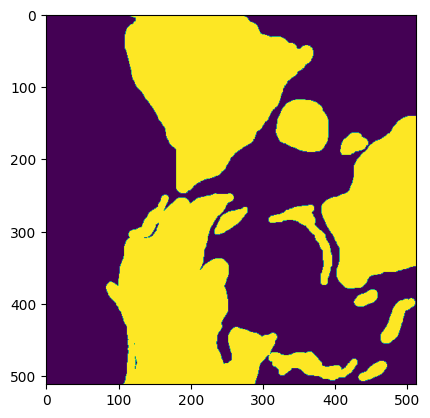

In [11]:
masks = get_masks(image_ids[434])
plt.imshow(masks.sum(0).clip(0, 1))

In [12]:
def draw_masks(image, masks):
    image_t = torch.tensor(image.transpose(2, 0, 1), dtype=torch.uint8)
    draw = draw_segmentation_masks(
        image=image_t,
        masks=torch.tensor(masks).to(torch.bool),
        colors=["green"] * len(masks),
        alpha=0.5
    )
    return draw.numpy().transpose(1, 2, 0)

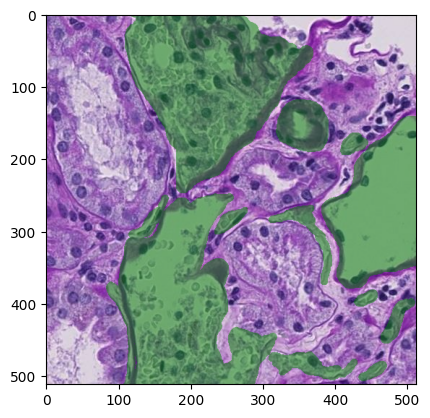

In [13]:
with_masks = draw_masks(image, masks)
plt.imshow(with_masks)

# Load baseline model

In [14]:
model = get_maskrcnn()
model.load_state_dict(torch.load("../models/mask_r-cnn/baseline.pth"))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [15]:
def get_predictions(image, model, threshold=0.5):
    image_t = to_tensor(image)
    with torch.no_grad():
        preds = model(image_t.unsqueeze(0))[0]
    n = 0
    scores = preds["scores"]
    while n < len(scores) and scores[n] > threshold:
        n += 1
    output = {}
    output["masks"] = preds["masks"][:n, 0]
    output["boxes"] = preds["boxes"][:n]
    output["scores"] = scores[:n]
    return output

preds = get_predictions(image, model)
{k: v.shape for k, v in preds.items()}

{'masks': torch.Size([14, 512, 512]),
 'boxes': torch.Size([14, 4]),
 'scores': torch.Size([14])}

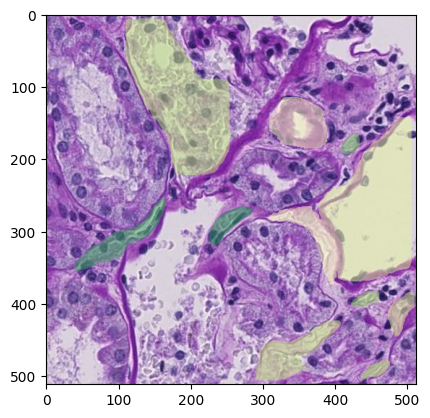

In [16]:
def draw_detections(image, preds):
    masks = preds["masks"].round().to(torch.uint8).to(torch.bool)
    scores = preds["scores"].numpy()
    colors = plt.cm.RdYlGn(scores)[:, :3]
    colors = (colors * 255).clip(0, 255).round().astype(np.uint8)
    colors = [tuple(c) for c in colors]
    draw = draw_segmentation_masks(
        image=torch.tensor(image.transpose(2, 0, 1)),
        masks=masks,
        colors=colors,
        alpha=0.5
    )
    return draw.numpy().transpose(1, 2, 0)

draw = draw_detections(image, preds)
plt.imshow(draw)

# Match and filter detections

In [17]:
def mask_iou(m1: np.ndarray, m2: np.ndarray) -> float:
    return (m1 * m2).sum() / (m1 + m2).clip(0, 1).sum()

[mask_iou(masks[0], m) for m in preds["masks"].numpy().round().astype(np.uint8)]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8636677245756865,
 0.0018103738632536208,
 0.0]

In [18]:
def filter_masks(masks, predictions, iou_thresh: float = 0.33, conf_thresh: float = 0.85):
    """
    1. Keep only masks that have matching (iou > iou_thresh) predictions
    2. Add unused masks with confidence > conf_thresh
    """
    pred = predictions["masks"].numpy().round().astype(np.uint8)
    scores = predictions["scores"].numpy()
    keep = np.zeros(len(masks), dtype=bool)
    used = np.zeros(len(pred), dtype=bool)

    for i, mask in enumerate(masks):
        iou = np.array([mask_iou(mask, pred_i) for pred_i in pred])
        if (iou > iou_thresh).any():
            keep[i] = True
            used[np.argmax(iou)] = True
            # pred[used] can be reused but will not be added at the end

    unused_confident = np.logical_and(~used, scores > conf_thresh)
    if mask.any():
        return np.concatenate([masks[keep], pred[unused_confident]], axis=0)
    return masks[keep]

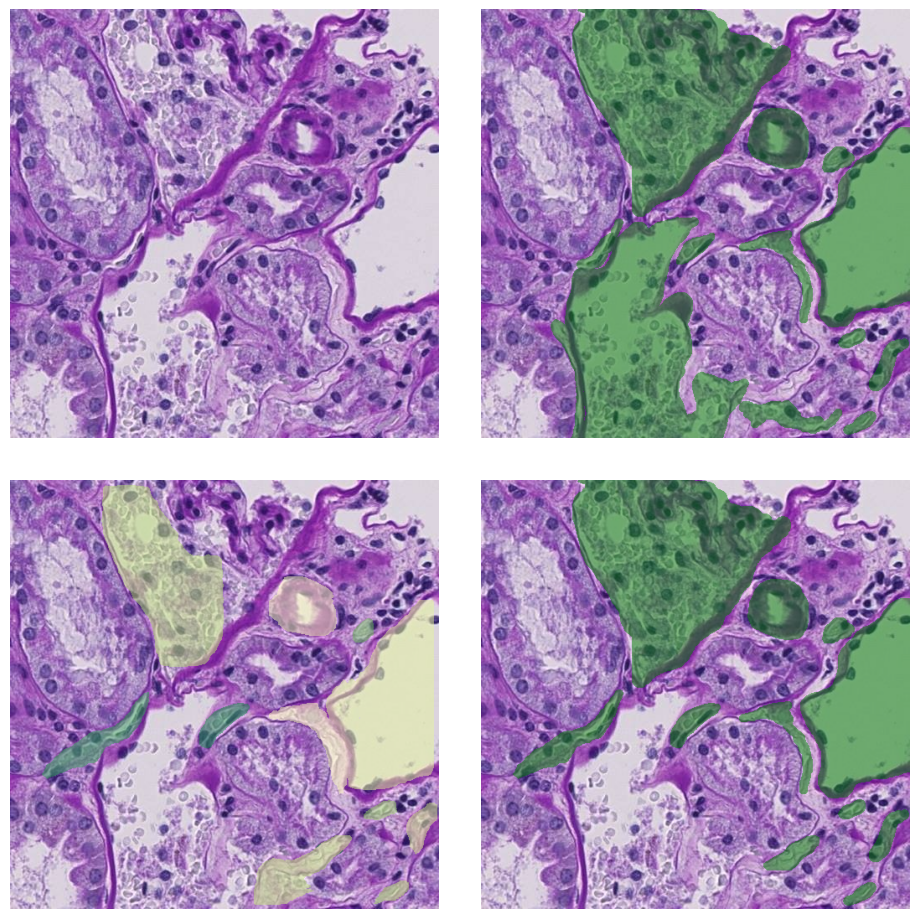

In [19]:
image_id = image_ids[434]
image = load_image(image_id)
masks = get_masks(image_id)
preds = get_predictions(image, model, 0.5)
masks_final = filter_masks(masks, preds)

fig, axes = plt.subplots(ncols=2, nrows=2)
axes = axes.ravel()
fig.set_size_inches((10, 10))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)
for ax in axes:
    ax.set_axis_off()
axes[0].imshow(image)
axes[1].imshow(draw_masks(image, masks))
axes[2].imshow(draw_detections(image, preds))
axes[3].imshow(draw_masks(image, masks_final))